# **2020 - 2024 Layoff Analysis**

### Overview

In the wake of global economic uncertainty, businesses are navigating turbulent times, often resulting in substantial layoffs. The impact is particularly pronounced in the tech sector, which has witnessed the loss of over 257,000 jobs, surpassing even the challenges posed by the pandemic. This project delves into the intricate dynamics of these layoffs, exploring affected industries, geographical patterns, and strategic implications. Leveraging Jupyter Notebook, we present a comprehensive analysis that sheds light on the evolving employment landscape, providing valuable insights for businesses, policymakers, and analysts alike.

### Layoffs Dataset

This dataset contains 2,738 rows and 12 columns, and was scraped from [Layoffs.fyi](https://layoffs.fyi/). Original dataset can be found on [Kaggle](https://www.kaggle.com/datasets/theakhilb/layoffs-data-2022/data).

| Field                        | Description                                      |
|------------------------------|--------------------------------------------------|
| Company                      | Name of the company                              |
| Location                     | Location of the company                          |
| Industry                     | Type of industry                                 |
| Layoffs               | Total layoff count                               |
| Percentage                   | Percentage of layoff                             |
| Date                         | Date of layoff                                   |
| Source                       | Source of data                                   |
| Funds_Raised                 | Total funds raised                               |
| Stage                        | Stage of the company                             |
| Date_Added                   | Date added in database                           |
| Country                      | Country of company location                      |
| List_of_Employees_Laid_Off   | Link to Google Docs of employee list             |

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
# Loading the dataset
df = pd.read_csv("D:\Dekstop\Practice\Python\CSV\Layoff_Analysis_2020-2024.csv")

df.head() # Notice the last column, 'List_of_Employees_Laid_Off', has only 'Unknown' values

,Company,Location_HQ,Industry,Laid_Off_Count,Percentage,Date,Source,Funds_Raised,Stage,Date_Added,Country,List_of_Employees_Laid_Off
0,Salesforce,SF Bay Area,Sales,700.0,0.01,2024-01-26,https://www.wsj.com/economy/jobs/salesforce-la...,65.0,Post-IPO,2024-01-26 14:26:09,United States,Unknown
1,Flexport,SF Bay Area,Logistics,NaN,0.20,2024-01-26,https://www.theinformation.com/articles/flexpo...,2400.0,Series E,2024-01-26 19:48:39,United States,Unknown
2,Microsoft,Seattle,Other,1900.0,NaN,2024-01-25,https://www.theverge.com/2024/1/25/24049050/mi...,1.0,Post-IPO,2024-01-25 14:42:40,United States,Unknown
3,Swiggy,Bengaluru,Food,400.0,0.07,2024-01-25,https://techcrunch.com/2024/01/25/swiggy-to-cu...,3600.0,Unknown,2024-01-25 14:45:14,India,Unknown
4,Veho,Boulder,Logistics,65.0,0.19,2024-01-25,https://techcrunch.com/2024/01/25/delivery-sta...,299.0,Series B,2024-01-26 19:50:26,United States,Unknown


# EDA - Cleaning
1. Understand variables
2. Clean dataset (missing data, redundant data, outliers)

### 1. Gather Information About the Data

In [3]:
df.info() # Notice the number of missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3374 entries, 0 to 3373
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Company                     3374 non-null   object 
 1   Location_HQ                 3374 non-null   object 
 2   Industry                    3374 non-null   object 
 3   Laid_Off_Count              2219 non-null   float64
 4   Percentage                  2172 non-null   float64
 5   Date                        3374 non-null   object 
 6   Source                      3374 non-null   object 
 7   Funds_Raised                3014 non-null   float64
 8   Stage                       3374 non-null   object 
 9   Date_Added                  3374 non-null   object 
 10  Country                     3374 non-null   object 
 11  List_of_Employees_Laid_Off  3373 non-null   object 
dtypes: float64(3), object(9)
memory usage: 316.4+ KB


In [4]:
df.describe()

,Laid_Off_Count,Percentage,Funds_Raised
count,2219.000000,2172.000000,3014.000000
mean,247.385759,0.277849,774.266986
std,781.980691,0.282074,4850.752433
min,3.000000,0.000000,0.000000
25%,40.000000,0.100000,51.000000
50%,80.000000,0.170000,163.000000
75%,180.000000,0.300000,455.200000
max,12000.000000,1.000000,121900.000000


### 2a) Check Missing Variables

In [5]:
print('Percentage of Missing Values')
(df.isna().mean() * 100).round(1)

Percentage of Missing Values


Company                        0.0
Location_HQ                    0.0
Industry                       0.0
Laid_Off_Count                34.2
Percentage                    35.6
Date                           0.0
Source                         0.0
Funds_Raised                  10.7
Stage                          0.0
Date_Added                     0.0
Country                        0.0
List_of_Employees_Laid_Off     0.0
dtype: float64

In [6]:
# Since I can't impute Percentage values, which could bias the amount of employees laid off, I'm losing 33.6% of the data when I remove blank rows
df.dropna(inplace = True)
df.isna().mean()

Company                       0.0
Location_HQ                   0.0
Industry                      0.0
Laid_Off_Count                0.0
Percentage                    0.0
Date                          0.0
Source                        0.0
Funds_Raised                  0.0
Stage                         0.0
Date_Added                    0.0
Country                       0.0
List_of_Employees_Laid_Off    0.0
dtype: float64

### 2b) Check for Duplicate Entries and Unnecessary Columns

In [7]:
print('Amount of duplicates: {:,}'.format(df.duplicated().sum()))

# These columns don't have much use in our analysis
df.drop(columns = ['List_of_Employees_Laid_Off', 'Source', 'Date_Added'], inplace = True)

df.rename(columns = {'Laid_Off_Count': 'Layoffs'}, inplace = True)

Amount of duplicates: 0


### 2c) Check Outliers

In [8]:
def detect_outliers(df, column_names):
    """
    Detect outliers in the specified columns of a DataFrame and visualize the results.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column_names (list): A list of column names to analyze for outliers.

    Returns:
    - pd.DataFrame: A DataFrame containing information about outliers for each specified column.
      Columns: ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit']
    """

    # Calculate the number of columns and rows for subplots
    col_len = len(column_names)
    num_columns = min(col_len, 3)
    num_rows = 2 * ((col_len + num_columns - 1) // num_columns)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 3 * num_rows), squeeze = False)

    # Initialize a list to store outlier information for each column
    outlier_data = []

    # Iterate over column_names and create subplots
    for i, column_name in enumerate(column_names):
        data = df[column_name]

        # Calculate quartiles and interquartile range using np.percentile
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1

        # Define lower and upper limits for outlier detection
        low_lim, upp_lim = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        # Find and display outliers
        outliers = df[(data < low_lim) | (data > upp_lim)][column_name]
        num_outliers = len(outliers)
        percent_outliers = round(num_outliers / len(df) * 100, 1)

        # Append outlier information to the list
        outlier_data.append([column_name, num_outliers, percent_outliers, round(low_lim, 1), round(upp_lim, 1)])

        # Calculate row and column indices for plotting
        row_index, col_index = divmod(i, num_columns * 2)

        # Create a boxplot to visualize the distribution and detect outliers
        ax_box, ax_hist = axes[row_index, col_index], axes[row_index + 1, col_index]
        sns.boxplot(x = data, ax = ax_box)
        ax_box.set(title = column_name.capitalize(), xlabel = None)
        ax_box.axvline(low_lim, color = 'red', linestyle = '--', label = f'Lower Limit: {low_lim:.1f}')
        ax_box.axvline(upp_lim, color = 'red', linestyle = '--', label = f'Upper Limit: {upp_lim:.1f}')
        ax_box.legend()

        # Create a histogram below the boxplot
        sns.histplot(data, bins = 20, ax = ax_hist, color = '#FF8C00')
        ax_hist.set(xlabel = None)
        ax_hist.set_yscale('log')  # Set y-axis scale to logarithmic
        ax_hist.set_ylabel(None)  # Disable y-axis label

    # Display the subplots
    plt.tight_layout()
    plt.show()

    # Combine the outlier information into a DataFrame
    outlier_df = pd.DataFrame(outlier_data, columns = ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit'])
    return outlier_df

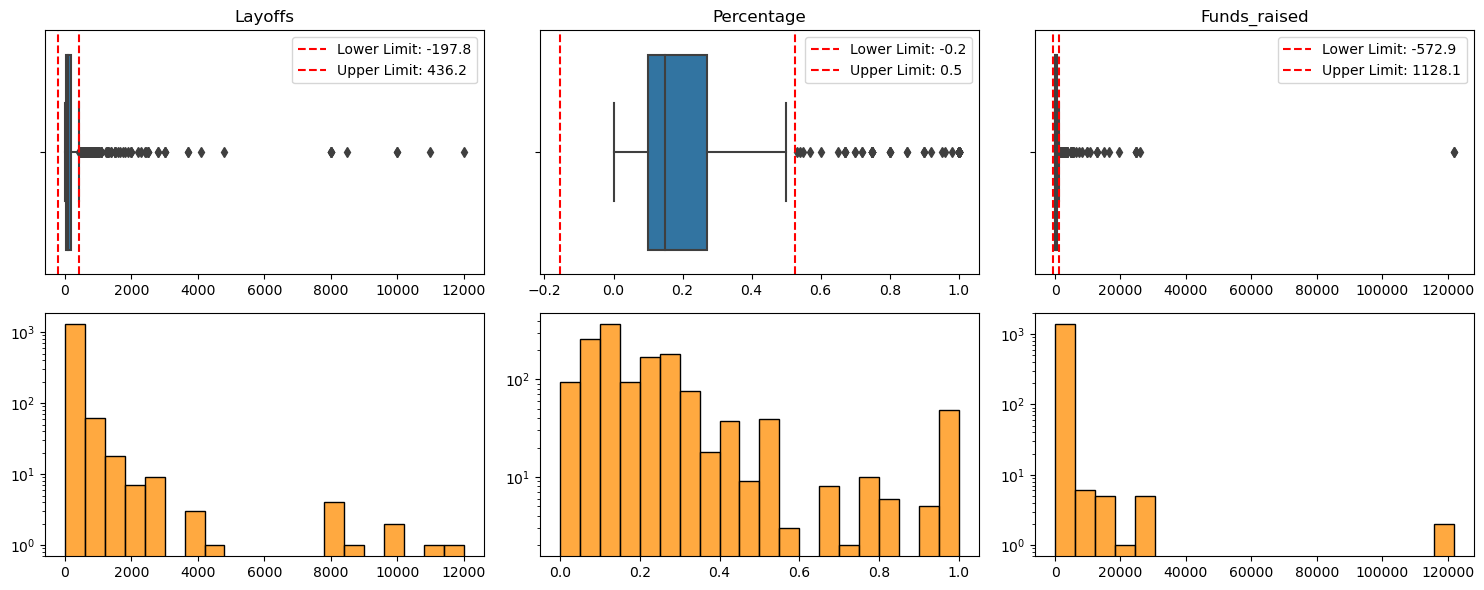

,Column,Number of Outliers,% Outliers,Lower Limit,Upper Limit
0,Layoffs,155,10.9,-197.8,436.2
1,Percentage,85,6.0,-0.2,0.5
2,Funds_Raised,152,10.7,-572.9,1128.1


In [9]:
outlier_col = df.select_dtypes(include = 'float').columns
detect_outliers(df, outlier_col)

In [10]:
# I'm removing 133 rows of outliers. Previously had 2,738 rows and cleaned 64% of the data.
clean_df = df.query('Percentage < 0.6 and Funds_Raised < 1108.2 and Layoffs < 416.2')
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1115 entries, 4 to 3372
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1115 non-null   object 
 1   Location_HQ   1115 non-null   object 
 2   Industry      1115 non-null   object 
 3   Layoffs       1115 non-null   float64
 4   Percentage    1115 non-null   float64
 5   Date          1115 non-null   object 
 6   Funds_Raised  1115 non-null   float64
 7   Stage         1115 non-null   object 
 8   Country       1115 non-null   object 
dtypes: float64(3), object(6)
memory usage: 87.1+ KB


# EDA - Visualizations

## 1. Industry Layoffs

In [11]:
# Box plot distribution of layoffs across industries
fig_industries_box = px.box(
    clean_df,
    x = 'Industry',
    y = 'Layoffs',
    title = 'Distribution of Layoffs Across Industries',
    color = 'Industry'
)

fig_industries_box.update_layout(title_x = 0.5)

fig_industries_box.show()

In [12]:
# Grouping by industry and summing the layoffs
industry_layoffs = (clean_df
    .groupby('Industry')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .head(10)
)

# Bar chart for top industries with the most layoffs
fig_industries = px.bar(
    industry_layoffs,
    title = 'Industries with the Most Layoffs',
    color = industry_layoffs.index.isin(industry_layoffs.head(3).index),
    color_discrete_map = {False: 'blue', True: 'darkred'}
)

# Update layout to remove legend, set y-axis label, and center title
fig_industries.update_layout(
    showlegend = False,
    yaxis_title = 'Layoffs',
    title_x = 0.5
)

fig_industries.show()

In [13]:
# Enhanced scatter plot for layoffs vs. funds raised colored by industry
fig_funds = px.scatter(
    clean_df,
    x = 'Funds_Raised',
    y = 'Layoffs',
    title = 'Layoffs vs. Funds Raised by Industry',
    color = 'Industry',
    hover_name = 'Company',
    labels = {'Funds_Raised': 'Funds Raised in Millions'}
)

# Formatting title and x-axis
fig_funds.update_layout(
    title_x = 0.5,
    xaxis_tickprefix = '$',
    xaxis_tickformat = ',.0f'
)

fig_funds.update_traces(marker = {'line': {'color': '#800080', 'width': 1}})

fig_funds.show()

## 3. Layoffs Over Time

In [14]:
# Convert the 'Date' column to a datetime format
clean_df.loc[:, 'Date'] = pd.to_datetime(clean_df['Date'])

# Group by date and sum the layoffs
date_layoffs = (
    clean_df
    .groupby('Date')['Layoffs']
    .sum()
    .reset_index()
)

# Time series plot for layoffs over time
fig_date = px.line(
    date_layoffs,
    x = 'Date',
    y = 'Layoffs',
    title = 'Trend of Layoffs',
    template = 'plotly_dark'
)

fig_date.update_layout(title_x = 0.5)
fig_date.update_traces(line_color = 'orange')

fig_date.show()

In [15]:
# Calculate cumulative layoffs over time
df_sorted_date = clean_df.sort_values(by = 'Date')
df_sorted_date['Cumulative_Layoffs'] = df_sorted_date['Layoffs'].cumsum()

# Enhanced time series for cumulative layoffs over time
fig_cum_date = px.line(
    df_sorted_date,
    x = 'Date',
    y = 'Cumulative_Layoffs',
    title = 'Cumulative Layoffs Over Time',
    template = 'plotly_dark',
    labels = {'Cumulative_Layoffs': 'Cumulative Number of Layoffs'}
)

fig_cum_date.update_layout(title_x = 0.5)
fig_cum_date.update_traces(line = dict(color = 'red', width = 2.5))

fig_cum_date.show()

## 4. Company Layoffs & Funds

In [16]:
# Group by company and sum the layoffs
company_layoffs = (
    clean_df
    .groupby('Company')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .head(10)
    .reset_index()
)

# Bar chart for companies with the highest number of layoffs
fig_company = px.bar(
    company_layoffs,
    x = 'Company',
    y = 'Layoffs',
    title = 'Companies with the Highest Layoffs',
    color = company_layoffs.index.isin(company_layoffs.head(1).index).astype(str),
    color_discrete_map = {'False': 'blue', 'True': 'darkred'}
)

fig_company.update_layout(
    title_x = 0.5,
    showlegend = False
)

fig_company.show()

In [17]:
# Grouping by companies and summing funds
funds_layoffs = (
    clean_df
    .groupby('Company')['Funds_Raised']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
    .head(10)
)

# Histogram for distribution of funds raised by companies
fig_funds = px.bar(
    funds_layoffs,
    x = 'Company',
    y = 'Funds_Raised',
    title = 'Funds Raised by Companies',
    labels = {'Funds_Raised': 'Amount of Funds Raised in Millions'},
    color = np.where(funds_layoffs.index < 3, True, False),
    color_discrete_map = {True: 'darkred', False: 'blue'}
)

# Format y-axis ticks
fig_funds.update_layout(
    title_x = 0.5,
    yaxis_tickprefix = '$',
    yaxis_tickformat = ',.0f',
    showlegend = False
)

fig_funds.show()

## 5. Company Stages During Layoffs

In [18]:
# Group by stage and sum the layoffs
stage_layoffs = (
    clean_df
    .groupby('Stage')['Layoffs']
    .sum()
    .reset_index()
)

# Find the index of the row with the maximum 'Layoffs'
max_layoffs_index = stage_layoffs['Layoffs'].idxmax()

# Create a color array where only the maximum index is True and everything else False
colors = [i == max_layoffs_index for i in stage_layoffs.index]

# Histogram for distribution of company stages among the layoffs
fig_stage = px.bar(
    stage_layoffs,
    x = 'Stage',
    y = 'Layoffs',
    title = 'Amount of Layoffs Across Different Company Phases',
    color = colors,
    color_discrete_map = {False: 'blue', True: 'darkred'},
    labels = {'Stage': 'Company Stage'}
)

fig_stage.update_layout(title_x = 0.5, showlegend = False)

fig_stage.show()

## 6. Countries, Layoffs, & Funds

In [19]:
# Group by country and sum the layoffs
country_layoffs = (
    clean_df
    .groupby('Country')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
)

# Bar chart for total layoffs by country
fig_country_layoffs = px.bar(
    country_layoffs,
    x = 'Country',
    y = 'Layoffs',
    title = 'Total Layoffs by Country',
    color = np.where(country_layoffs.index == 0, True, False),
    color_discrete_map = {True: 'darkred', False: 'blue'}
)

fig_country_layoffs.update_layout(title_x = 0.5, showlegend = False)

fig_country_layoffs.show()

In [20]:
# Group by country and sum the layoffs
country_layoffs = (
    clean_df
    .groupby('Country')['Layoffs']
    .sum()
    .reset_index()
)

# Map visualization for countries with layoffs
fig_country = px.choropleth(
    country_layoffs,
    locations = 'Country',
    locationmode = 'country names',
    hover_name = 'Country',
    title = 'Layoffs by Country',
    color = 'Layoffs',
    color_continuous_scale = px.colors.sequential.Plasma
)

fig_country.update_layout(title_x = 0.5)

fig_country.show()

In [21]:
# Group by country and calculate the average funds raised
country_avg_funds = (
    clean_df
    .groupby('Country')['Funds_Raised']
    .mean()
    .sort_values(ascending = False)
    .reset_index()
)

# Map visualization for countries with layoffs
fig_country_avg_funds = px.choropleth(
    country_avg_funds,
    locations = 'Country',
    locationmode = 'country names',
    hover_name = 'Country',
    title = 'Average Raised Funds by Country',
    color = 'Funds_Raised',
    color_continuous_scale = px.colors.sequential.Inferno
)

fig_country_avg_funds.update_layout(title_x = 0.5)

fig_country_avg_funds.show()

## 7. Locations with the Most Layoffs

In [22]:
# Group by location and sum the layoffs
location_layoffs = (
    clean_df
    .groupby('Location_HQ')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
    .head(10)
)

# Bar chart for top locations with the most layoffs
fig_location = px.bar(
    location_layoffs,
    x = 'Location_HQ',
    y = 'Layoffs',
    title = 'Top Locations with the Highest Layoffs',
    labels = {'Location_HQ': 'HQ Location'},
    color = np.where(location_layoffs.index == location_layoffs['Layoffs'].idxmax(), True, False),
    color_discrete_map = {True: 'darkred', False: 'blue'}
)

fig_location.update_layout(title_x = 0.5, showlegend = False)

fig_location.show()

## Report on US Layoffs

In [23]:
# Obtaining only US-related data
usa_clean_df = clean_df[clean_df['Country'] == 'United States']

# Comparing with uncleaned data
usa_df = df[df['Country'] == 'United States']

usa_clean_df.head()

,Company,Location_HQ,Industry,Layoffs,Percentage,Date,Funds_Raised,Stage,Country
4,Veho,Boulder,Logistics,65.0,0.19,2024-01-25 00:00:00,299.0,Series B,United States
33,SonderMind,Denver,Healthcare,49.0,0.17,2024-01-16 00:00:00,183.0,Series C,United States
34,First Mode,Seattle,Transportation,48.0,0.20,2024-01-16 00:00:00,9.0,Acquired,United States
45,Discord,SF Bay Area,Consumer,170.0,0.17,2024-01-11 00:00:00,995.0,Series H,United States
47,Audible,New York City,Media,100.0,0.05,2024-01-11 00:00:00,14.0,Acquired,United States


## US Data Overview

In [24]:
# Calculate aggregated statistics
num_companies = [usa_clean_df['Company'].nunique(), usa_df['Company'].nunique()]
total_layoffs = [usa_clean_df['Layoffs'].sum(), usa_df['Layoffs'].sum()]
avg_funds_raised = [usa_clean_df['Funds_Raised'].mean(), usa_df['Funds_Raised'].mean()]
total_funds_raised = [usa_clean_df['Funds_Raised'].sum(), usa_df['Funds_Raised'].sum()]

usa_data = {
    'Number of Companies': num_companies,
    'Total Layoffs': total_layoffs,
    'Avg Funds Raised in Millions ($)': avg_funds_raised,
    'Total Funds Raised in Millions ($)': total_funds_raised,
}

usa = pd.DataFrame(usa_data, index = ['Cleaned Data', 'Raw Data'])

# Formatting DataFrame
usa = usa.astype(int)
usa

,Number of Companies,Total Layoffs,Avg Funds Raised in Millions ($),Total Funds Raised in Millions ($)
Cleaned Data,600,66454,271,196135
Raw Data,737,260634,876,817962


In [25]:
# Top industry layoffs in USA

top_industries_clean = (
    usa_clean_df
    .groupby('Industry')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .head(10)
    .reset_index()
)

top_industries_raw = (
    usa_df
    .groupby('Industry')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .head(10)
    .reset_index()
)

# Add 'Label' column to identify cleaned and raw data
top_industries_clean['Label'] = 'Cleaned Data'
top_industries_raw['Label'] = 'Raw Data'

# Combine the DataFrames
top_industries = (
    pd.concat([top_industries_clean, top_industries_raw])
    .sort_values(by = 'Layoffs', ascending = False)
)

# Create bar plot
fig_industries_compare = px.bar(
    top_industries,
    x = 'Industry',
    y = 'Layoffs',
    color = 'Label',
    title = 'US Industries with the Highest Workforce Reductions',
    barmode = 'overlay',
    color_discrete_map = {'Raw Data': 'darkorange', 'Cleaned Data': 'blue'}
)

fig_industries_compare.update_layout(title_x = 0.5, legend = {'title': ''})

fig_industries_compare.show()

In [26]:
# Different company stages with the highest number of layoffs for cleaned and raw data
company_stages_clean = (
    usa_clean_df
    .groupby('Stage')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
)

company_stages_raw = (
    usa_df
    .groupby('Stage')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
)

# Add 'Label' column to identify cleaned and raw data
company_stages_clean['Label'] = 'Cleaned Data'
company_stages_raw['Label'] = 'Raw Data'

# Combine the DataFrames
stage_data = pd.concat([company_stages_clean, company_stages_raw])

fig_stage_compare = px.bar(
    stage_data,
    x = 'Stage',
    y = 'Layoffs',
    color = 'Label',
    title = 'Company Stages During Layoffs',
    barmode = 'overlay',
    color_discrete_map = {'Raw Data': 'darkorange', 'Cleaned Data': 'blue'}
)

fig_stage_compare.update_layout(title_x = 0.5, legend = {'title' : ''})

fig_stage_compare.show()

In [27]:
# Comparing pie charts of different company stages for US companies during layoffs

pie_stage_clean = px.pie(
    company_stages_clean,
    names = company_stages_clean.set_index('Stage').index,
    values = 'Layoffs',
    title = 'Layoffs by Company Stage (Clean Data)'
)

pie_stage_raw = px.pie(
    company_stages_raw,
    names = company_stages_raw.set_index('Stage').index,
    values = 'Layoffs',
    title = 'Layoffs by Company Stage (Raw Data)'
)

pie_stage_clean.show()
pie_stage_raw.show()

In [28]:
# Top Companies with highest layoffs (Cleaned Data)
top_companies_clean = (
    usa_clean_df
    .groupby('Company')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
    .head(10)
)

# Top Companies with highest layoffs (Raw Data)
top_companies_raw = (
    usa_df
    .groupby('Company')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
    .head(10)
)

# Bar chart for Top 10 US Layoffs by Companies (Cleaned Data)
bar_company_clean = px.bar(
    top_companies_clean,
    x = 'Company',
    y = 'Layoffs',
    title = 'Top 10 US Company Layoffs (Cleaned Data)',
    color = np.where(top_companies_clean.index == top_companies_clean['Layoffs'].idxmax(), True, False),
    color_discrete_map = {True: 'darkorange', False: 'darkblue'}
)

# Bar chart for Top 10 US Layoffs by Companies (Raw Data)
bar_company_raw = px.bar(
    top_companies_raw,
    x = 'Company',
    y = 'Layoffs',
    title = 'Top 10 US Company Layoffs',
    color = np.where(top_companies_raw.index == top_companies_raw['Layoffs'].idxmax(), True, False),
    color_discrete_map = {True: 'red', False: 'blue'}
)

# Update layout for both charts
for chart in [bar_company_clean, bar_company_raw]:
    chart.update_layout(title_x = 0.5, showlegend = False)

# Show the charts
bar_company_clean.show()
bar_company_raw.show()

In [29]:
# Group by US location and sum the layoffs (Cleaned Data)
location_layoffs_us_clean = (
    usa_clean_df
    .groupby('Location_HQ')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
    .head(10)
)

# Group by US location and sum the layoffs (Raw Data)
location_layoffs_us_raw = (
    usa_df
    .groupby('Location_HQ')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
    .head(10)
)

# Combine both datasets
combined_data = pd.concat(
    [location_layoffs_us_raw.assign(Data = 'Raw Data'),
    location_layoffs_us_clean.assign(Data = 'Cleaned Data')]
)

# Bar chart for US locations with the most layoffs
fig_combined_location_layoffs = px.bar(
    combined_data,
    x = 'Location_HQ',
    y = 'Layoffs',
    title = 'Highest US Layoffs by Location',
    labels = {'Location_HQ': 'HQ Location'},
    barmode = 'overlay',
    color = 'Data',
    color_discrete_map = {'Cleaned Data': 'blue', 'Raw Data': 'darkorange'}
)

# Update layout for the combined chart
fig_combined_location_layoffs.update_layout(title = {'x': 0.5}, legend = {'title' : ''})

# Show the combined chart
fig_combined_location_layoffs.show()

In [30]:
# Trend of layoffs in USA (cleaned data)
layoffs_trend_clean = (
    usa_clean_df
    .groupby('Date')['Layoffs']
    .sum()
    .reset_index()
)

# Trend of layoffs in USA (raw data)
layoffs_trend_raw = (
    usa_df
    .groupby('Date')['Layoffs']
    .sum()
    .reset_index()
)

# Add 'Label' column to identify cleaned and raw data
layoffs_trend_clean['Label'] = 'Cleaned Data'
layoffs_trend_raw['Label'] = 'Raw Data'

# Combine the DataFrames
trend_data = pd.concat([layoffs_trend_clean, layoffs_trend_raw])

# Plotting the trends
fig_trend_compare = px.line(
    trend_data,
    x = 'Date',
    y = 'Layoffs',
    color = 'Label',
    title = 'Layoffs Over Time in the United States of America',
    template = 'plotly_dark'
)

# Updating formatting
fig_trend_compare.update_layout(title = {'x': 0.5}, legend = {'title': ''})

fig_trend_compare.show()

In [31]:
# Ignoring Pandas warnings
pd.set_option('mode.chained_assignment', None)

# Add 'Month' column with period format
usa_clean_df.loc[:, 'Month'] = pd.to_datetime(usa_clean_df['Date']).dt.to_period('M')
usa_df.loc[:, 'Month'] = pd.to_datetime(usa_df['Date']).dt.to_period('M')

# Calculate top layoffs for cleaned and raw data
month_layoffs_clean = (
    usa_clean_df
    .groupby('Month')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .head(10)
    .reset_index()
)

month_layoffs_raw = (
    usa_df
    .groupby('Month')['Layoffs']
    .sum()
    .sort_values(ascending = False)
    .head(10)
    .reset_index()
)

# Add 'Label' column to identify cleaned and raw data
month_layoffs_clean.loc[:, 'Label'] = 'Cleaned Data'
month_layoffs_raw.loc[:, 'Label'] = 'Raw Data'

# Concatenate and set index
month_df = pd.concat([month_layoffs_clean, month_layoffs_raw]).sort_values(by = 'Layoffs')

# Formatting 'Layoffs' column
month_df['Layoffs'] = month_df['Layoffs'].apply('{:,.0f}'.format)

# Convert 'Month' to string
month_df['Month'] = month_df['Month'].astype(str)

# Plotting bar graph of top layoffs by month
fig_month = px.bar(
    month_df,
    x = 'Month',
    y = 'Layoffs',
    title = 'Months with the Highest Layoffs in the US',
    color = 'Label',
    barmode = 'overlay'
)

# Update layout
fig_month.update_layout(title_x = 0.5)

# Show the plot
fig_month.show()

# Hide index in the displayed DataFrame
month_df.style.hide(axis = 'index')

Month,Layoffs,Label
2022-07,"2,667",Cleaned Data
2022-08,"3,229",Cleaned Data
2022-12,"3,482",Cleaned Data
2022-10,"3,498",Cleaned Data
2023-02,"4,158",Cleaned Data
2022-06,"4,462",Cleaned Data
2020-03,"4,524",Cleaned Data
2022-11,"4,656",Cleaned Data
2023-01,"5,106",Cleaned Data
2022-07,"6,752",Raw Data


In [32]:
# Companies in the US with high funds raised and significant layoffs

# Removing timestamp from 'Date' column
usa_clean_df.loc[:, 'Date'] = pd.to_datetime(usa_clean_df['Date']).dt.date

top_funded_companies_with_layoffs_clean = (
    usa_clean_df
    .sort_values(by = ['Funds_Raised', 'Layoffs'], ascending = [False, False])
    .head(10)
    [['Company', 'Funds_Raised', 'Layoffs', 'Date']]
)

top_funded_companies_with_layoffs_raw = (
    usa_df
    .sort_values(by = ['Funds_Raised', 'Layoffs'], ascending = [False, False])
    .head(10)
    [['Company', 'Funds_Raised', 'Layoffs', 'Date']]
)

# Concatenate and set index
top_funded_layoffs_df = pd.concat([top_funded_companies_with_layoffs_clean, top_funded_companies_with_layoffs_raw], keys = ['Cleaned Data', 'Raw Data'])

top_funded_layoffs_df

Company  Funds_Raised  Layoffs        Date
Cleaned Data 2125       Nutanix        1100.0    270.0  2022-08-09
             1070  ServiceTitan        1100.0    221.0  2023-02-15
             1917     Momentive        1100.0    180.0  2022-10-10
             156       Dataminr        1100.0    150.0  2023-11-28
             1318         nCino        1100.0    100.0  2023-01-18
             2492        Convoy        1100.0     90.0  2022-06-09
             649        23andMe        1100.0     75.0  2023-06-09
             436        23andMe        1100.0     71.0  2023-08-08
             603         Convoy        1100.0     30.0  2023-06-26
             2475       BlockFi        1000.0    250.0  2022-06-13
Raw Data     2408       Netflix      121900.0    300.0  2022-06-23
             2597       Netflix      121900.0    150.0  2022-05-17
             1759          Meta       26000.0  11000.0  2022-11-09
             2947          Uber       24700.0   3700.0  2020-05-06
             2901          Uber       24700.0   3000.0  2020-05-18
             110         Cruise       15000.0    900.0  2023-12-14
             1791       Twitter       12900.0   3700.0  2022-11-04
             1020       Twitter       12900.0    200.0  2023-02-25
             2219        Rivian       10700.0    840.0  2022-07-27
             905   Lucid Motors        8300.0   1300.0  2023-03-28

## Overview of 2023 USA Layoff Data

In [33]:
# Filtering the dataset for 2023 data
usa_2023_clean_df = usa_clean_df[usa_clean_df['Date'].astype(str).str.contains('2023')]
usa_2023_raw_df = usa_df[usa_df['Date'].str.contains('2023')]

# Function to calculate average and total values for a given column
def calculate_metrics(df, column_name):
    metrics = (
        df.groupby('Industry')[column_name]
        .agg(['mean', 'sum'])
        .rename(columns = {'mean': f'Average {column_name}', 'sum': f'Total {column_name}'})
    )
    return metrics

# Average and total layoffs by industry in 2023 for cleaned and raw data
industry_2023_layoffs_clean = calculate_metrics(usa_2023_clean_df, 'Layoffs')
industry_2023_layoffs_raw = calculate_metrics(usa_2023_raw_df, 'Layoffs')

# Average and total funds raised by industry in 2023 for cleaned and raw data
industry_2023_funds_clean = calculate_metrics(usa_2023_clean_df, 'Funds_Raised')
industry_2023_funds_raw = calculate_metrics(usa_2023_raw_df, 'Funds_Raised')

# Merging the two dataframes for layoffs
industry_2023_clean = (
    industry_2023_layoffs_clean
    .join(industry_2023_funds_clean)
    .sort_values(by = 'Total Layoffs', ascending = False)
    .head(10)
)

industry_2023_raw = (
    industry_2023_layoffs_raw
    .join(industry_2023_funds_raw)
    .sort_values(by = 'Total Layoffs', ascending = False)
    .head(10)
)

# Concatenating the cleaned and raw dataframes with a multi-index
final_2023_usa_df = pd.concat([industry_2023_clean, industry_2023_raw], keys = ['Cleaned Data', 'Raw Data']).astype(int)

# Display the final DataFrame
final_2023_usa_df.rename(
    columns = {
        'Average Layoffs': 'Avg Layoffs',
        'Average Funds_Raised': 'Avg Funds Raised in Millions ($)',
        'Total Funds_Raised': 'Total Funds Raised in Millions ($)'
    }
)

Avg Layoffs  Total Layoffs  \
             Industry                                     
Cleaned Data Finance                  94           3492   
             Healthcare              133           3062   
             Other                   130           2614   
             Security                105           1691   
             Data                    125           1252   
             Media                   115           1153   
             Sales                   109            988   
             Retail                   78            863   
             HR                       92            833   
             Support                 132            795   
Raw Data     Other                   604          19942   
             Consumer               1240          16132   
             Retail                  700          12607   
             Sales                   811           9738   
             Hardware               1942           7770   
             Finance                 148           6528   
             Transportation          394           4739   
             Healthcare              149           4032   
             HR                      323           3558   
             Travel                  390           3123   

                             Avg Funds Raised in Millions ($)  \
             Industry                                           
Cleaned Data Finance                                      336   
             Healthcare                                   437   
             Other                                        283   
             Security                                     196   
             Data                                         353   
             Media                                        215   
             Sales                                        428   
             Retail                                       301   
             HR                                           310   
             Support                                      341   
Raw Data     Other                                        509   
             Consumer                                    1820   
             Retail                                       634   
             Sales                                        371   
             Hardware                                     126   
             Finance                                      596   
             Transportation                              3325   
             Healthcare                                   654   
             HR                                           275   
             Travel                                       522   

                             Total Funds Raised in Millions ($)  
             Industry                                            
Cleaned Data Finance                                      12446  
             Healthcare                                   10056  
             Other                                         5664  
             Security                                      3144  
             Data                                          3531  
             Media                                         2152  
             Sales                                         3860  
             Retail                                        3315  
             HR                                            2792  
             Support                                       2049  
Raw Data     Other                                        16809  
             Consumer                                     23661  
             Retail                                       11417  
             Sales                                         4463  
             Hardware                                       504  
             Finance                                      26262  
             Transportation                               39910  
             Healthcare                      

# Random Forest - Predicting When Layoffs Would Occur

In [34]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1115 entries, 4 to 3372
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1115 non-null   object 
 1   Location_HQ   1115 non-null   object 
 2   Industry      1115 non-null   object 
 3   Layoffs       1115 non-null   float64
 4   Percentage    1115 non-null   float64
 5   Date          1115 non-null   object 
 6   Funds_Raised  1115 non-null   float64
 7   Stage         1115 non-null   object 
 8   Country       1115 non-null   object 
dtypes: float64(3), object(6)
memory usage: 87.1+ KB


In [35]:
# Extract the month and create a new 'Month' column
clean_df['Month'] = pd.to_datetime(clean_df['Date']).dt.month

# Drop the 'Percentage' column
random_forest_clean = clean_df.drop(columns = ['Date', 'Percentage'])

random_forest_clean.head()

,Company,Location_HQ,Industry,Layoffs,Funds_Raised,Stage,Country,Month
4,Veho,Boulder,Logistics,65.0,299.0,Series B,United States,1
9,Storytel,Stockholm,Media,80.0,275.0,Post-IPO,Sweden,1
33,SonderMind,Denver,Healthcare,49.0,183.0,Series C,United States,1
34,First Mode,Seattle,Transportation,48.0,9.0,Acquired,United States,1
45,Discord,SF Bay Area,Consumer,170.0,995.0,Series H,United States,1


### Simple Version

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# One-hot encode categorical features
random_forest_clean_encoded = pd.get_dummies(random_forest_clean, columns = ['Company', 'Location_HQ', 'Industry', 'Stage', 'Country'], dtype = int)

# Define features and target
X = random_forest_clean_encoded.iloc[:,:-1]
y = random_forest_clean['Month']  # Target variable

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train the Random Forest model
model = RandomForestRegressor(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the regression model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation scores with 3 decimals
print(f'R-squared: {r2:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')

R-squared: 1.000
Mean Absolute Error: 0.000
Mean Squared Error: 0.000
Root Mean Squared Error: 0.000


In [37]:
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error

# One-hot encode categorical features
random_forest_clean_encoded = (
    pd.get_dummies(
        random_forest_clean,
        columns = ['Company', 'Location_HQ', 'Industry', 'Stage', 'Country'],
        dtype = int
    )
)

# Define features and target
X = random_forest_clean_encoded.iloc[:, :-1]
y = random_forest_clean['Month']  # Target variable

# Create a RandomForestRegressor
model = RandomForestRegressor(random_state = 42, n_jobs = -1)

# Define the evaluation metrics
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error'
}

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform cross-validation
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Create GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring = scoring, cv = cv, refit = 'r2', return_train_score = False, n_jobs = -1)
grid_search.fit(X, y)

# Print the best hyperparameters
print('Best Hyperparameters:', grid_search.best_params_)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the best model using cross-validation
cv_results = cross_validate(best_model, X, y, cv = cv, scoring = scoring)

# Print the cross-validated evaluation scores with 3 decimals
print(f'R-squared: {np.mean(cv_results["test_r2"]):.3f}')
print(f'Mean Absolute Error: {np.mean(cv_results["test_mae"]):.3f}')
print(f'Mean Squared Error: {np.mean(cv_results["test_mse"]):.3f}')
print(f'Root Mean Squared Error: {np.mean(cv_results["test_rmse"]):.3f}')

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
R-squared: 1.000
Mean Absolute Error: 0.000
Mean Squared Error: 0.000
Root Mean Squared Error: 0.000
